In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
from PIL import Image, ImageOps, UnidentifiedImageError
from collections import Counter
import tensorflow as tf
import os
import shutil
import pandas as pd
import pathlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Softmax
import time
import seaborn as sns

Data link: https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images

In [2]:
# Directory Path Setup
data = pathlib.Path("C:/Working/Github Project/archive/Mushrooms")

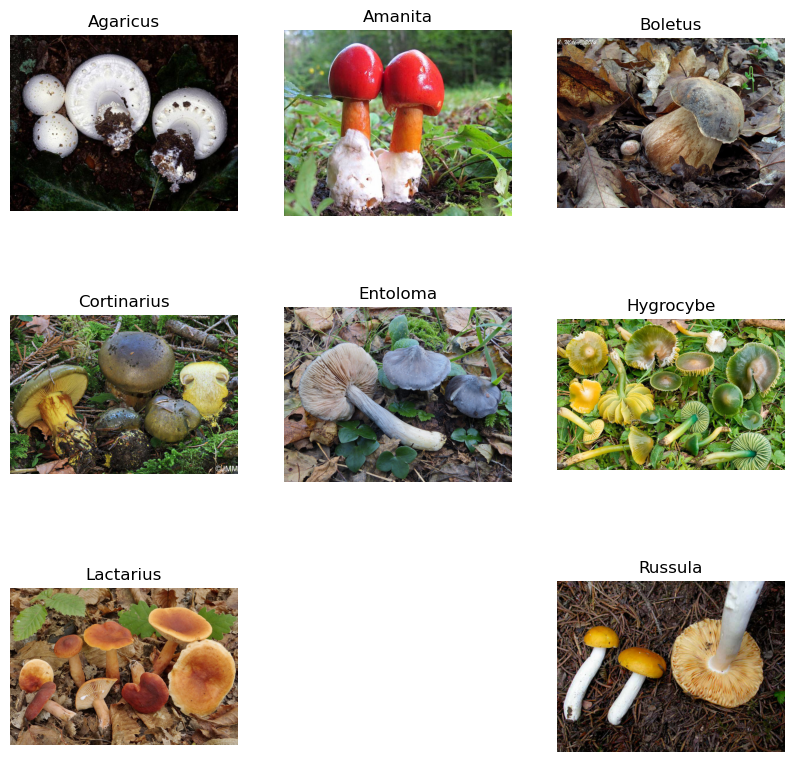

In [3]:
#  Display the first image from each subdirectory within a specified directory.

class_dirs = [d for d in data.iterdir() if d.is_dir()]
plt.figure(figsize=(10, 10))

for i, class_dir in enumerate(class_dirs):
    image_paths = list(class_dir.glob('*.jpg'))
    if image_paths:
        img = Image.open(str(image_paths[0]))
        plt.subplot(3, 3, i + 1)  
        plt.imshow(img)
        plt.title(class_dir.name)
        plt.axis('off')
        if i == 8:
            break

plt.show()

In [4]:
# Count and display the number of files in each subdirectory of a Mushroom main directory

# Dictionary to hold the count of files in each directory
dir_file_count = {}

# Iterate over each directory in the main directory
for class_dir in data.iterdir():
    if class_dir.is_dir():
        # Counting the number of files in each directory
        file_count = len(list(class_dir.glob('*.*')))  
        dir_file_count[class_dir.name] = file_count

# Sorting directories based on file count
sorted_dirs = sorted(dir_file_count.items(), key=lambda x: x[1], reverse=True)

# Display the sorted directories and their file counts
for dir_name, count in sorted_dirs:
    print(f"{dir_name}: {count} files")

Lactarius: 1563 files
Russula: 1148 files
Boletus: 1073 files
Cortinarius: 836 files
Amanita: 750 files
Entoloma: 364 files
Agaricus: 353 files
Hygrocybe: 316 files
Suillus: 311 files
Mushrooms: 0 files


In [5]:
# Display the top 8 subdirectories with the highest file counts

dir_counts = Counter({dir.name: len(list(dir.glob('*.*'))) for dir in data.iterdir() if dir.is_dir()})

top_8_dirs = dir_counts.most_common(8)

for dir_name, count in top_8_dirs:
    print(f"Class: {dir_name}, Image Count: {count}")

Class: Lactarius, Image Count: 1563
Class: Russula, Image Count: 1148
Class: Boletus, Image Count: 1073
Class: Cortinarius, Image Count: 836
Class: Amanita, Image Count: 750
Class: Entoloma, Image Count: 364
Class: Agaricus, Image Count: 353
Class: Hygrocybe, Image Count: 316


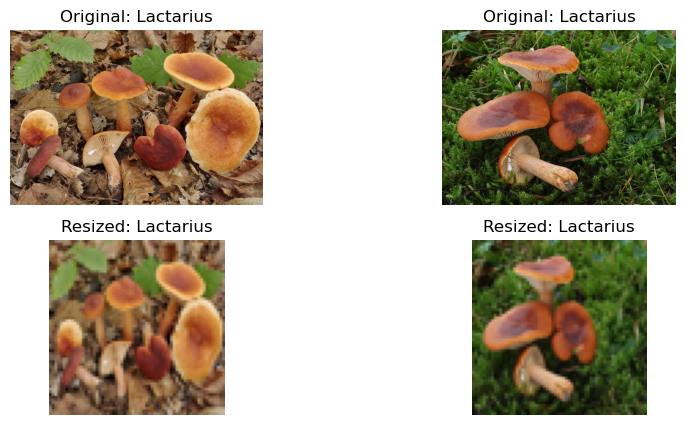

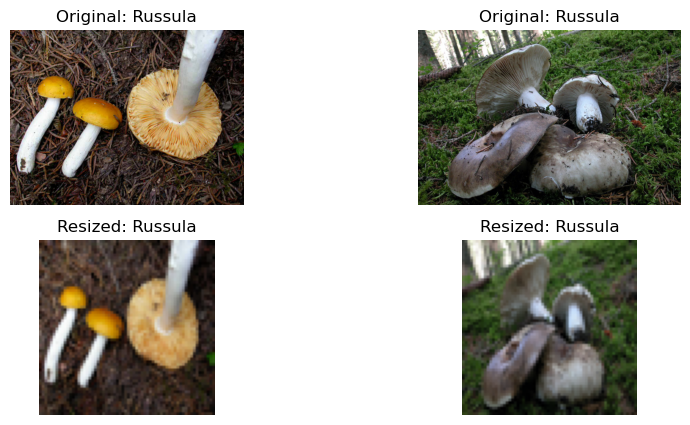

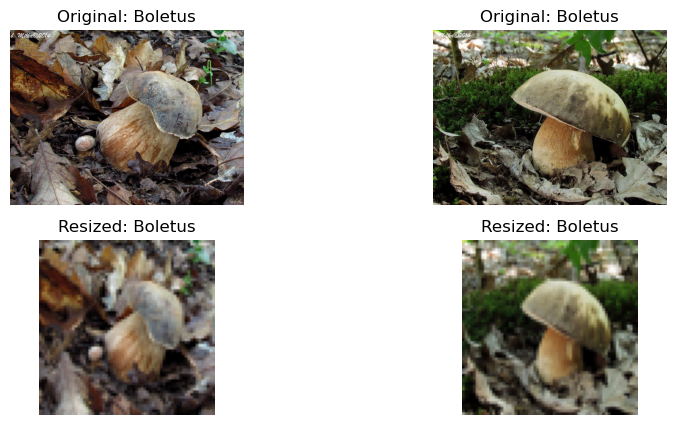

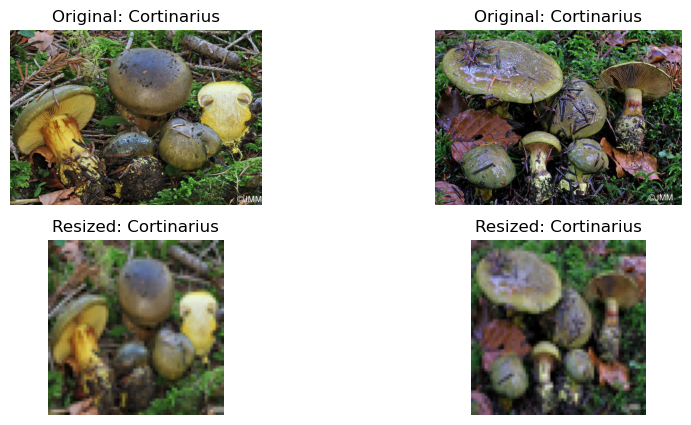

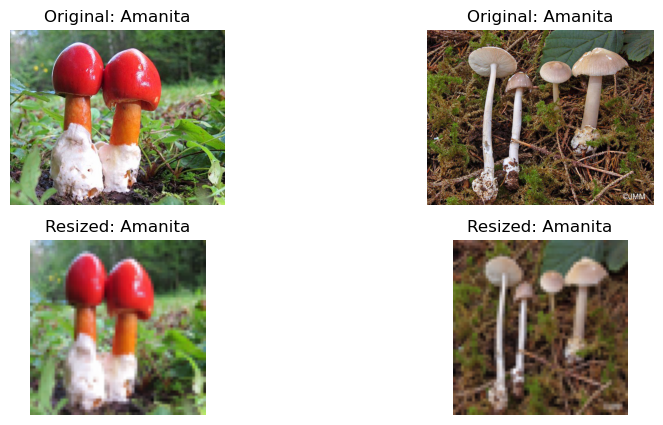

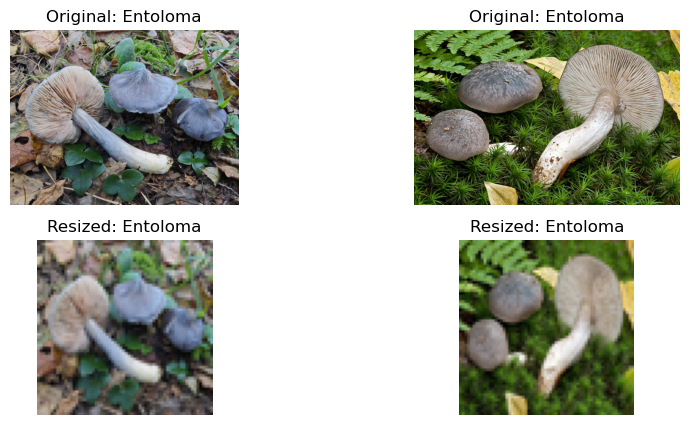

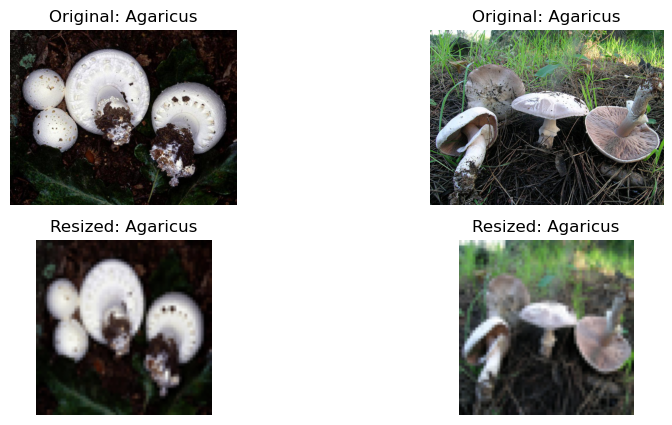

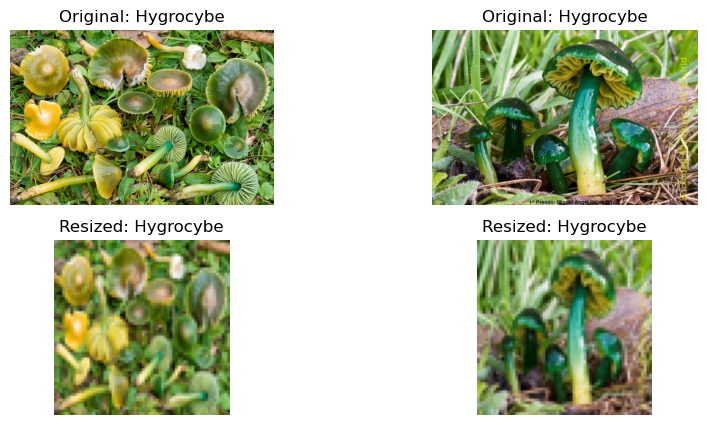

In [32]:
# Display the first two images from each of the top 8 subdirectories (classes)
# Showing both the original and resized versions of these images

dir_file_count = {}

for class_dir in data.iterdir():
    if class_dir.is_dir():

        file_count = len(list(class_dir.glob('*.jpg')))
        dir_file_count[class_dir.name] = file_count

top_8_classes = sorted(dir_file_count.items(), key=lambda x: x[1], reverse=True)[:8]

for class_name, _ in top_8_classes:
    class_dir = data / class_name
    image_paths = list(class_dir.glob('*.jpg'))[:2]  

    plt.figure(figsize=(10, 5))  
    for i, image_path in enumerate(image_paths):
        img = Image.open(str(image_path))

        plt.subplot(2, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f"Original: {class_name}")
        plt.axis('off')

        img_resized = img.resize((64, 64))  
        plt.subplot(2, len(image_paths), len(image_paths) + i + 1)
        plt.imshow(img_resized)
        plt.title(f"Resized: {class_name}")
        plt.axis('off')

    plt.show()

In [33]:
#  Save resized images in a new directory structure

original_data_path = pathlib.Path("C:/Working/Github Project/archive/Mushrooms")
new_data_path = pathlib.Path("C:/Working/Github Project/archive/ResizedMushrooms")
new_data_path.mkdir(parents=True, exist_ok=True)  

for class_name, _ in top_8_classes:
    new_class_dir = new_data_path / class_name
    new_class_dir.mkdir(parents=True, exist_ok=True)
    original_class_dir = original_data_path / class_name
    for image_path in original_class_dir.glob('*.jpg'):  
        try:
            img = Image.open(str(image_path))
            img_resized = img.resize((64, 64))  
            img_resized.save(new_class_dir / image_path.name) 
        except (OSError, UnidentifiedImageError):
            print(f"Skipping corrupted image: {image_path}")

    print(f"Resized images for class {class_name} saved in {new_class_dir}")

Resized images for class Lactarius saved in C:\Working\Github Project\archive\ResizedMushrooms\Lactarius
Skipping corrupted image: C:\Working\Github Project\archive\Mushrooms\Russula\092_43B354vYxm8.jpg
Resized images for class Russula saved in C:\Working\Github Project\archive\ResizedMushrooms\Russula
Resized images for class Boletus saved in C:\Working\Github Project\archive\ResizedMushrooms\Boletus
Resized images for class Cortinarius saved in C:\Working\Github Project\archive\ResizedMushrooms\Cortinarius
Resized images for class Amanita saved in C:\Working\Github Project\archive\ResizedMushrooms\Amanita
Resized images for class Entoloma saved in C:\Working\Github Project\archive\ResizedMushrooms\Entoloma
Resized images for class Agaricus saved in C:\Working\Github Project\archive\ResizedMushrooms\Agaricus
Resized images for class Hygrocybe saved in C:\Working\Github Project\archive\ResizedMushrooms\Hygrocybe


In [34]:
#  Verify the image size and count the number of images for each class in the resized image dataset

resized_data_path = pathlib.Path("C:/Working/Github Project/archive/ResizedMushrooms")

# Dictionary to hold the count of images for each class
class_image_counts = {}

# Iterate through each subdirectory in Resized8_data
for class_dir in resized_data_path.iterdir():
    if class_dir.is_dir():
        image_count = 0
        all_images_64x64 = True

        # Iterate through each image file in the directory
        for image_path in class_dir.glob('*.jpg'):
            with Image.open(image_path) as img:
                if img.size != (64, 64):
                    all_images_64x64 = False
                    break
                image_count += 1

        class_image_counts[class_dir.name] = image_count
        if all_images_64x64:
            print(f"All images in class '{class_dir.name}' are 64x64.")
        else:
            print(f"Warning: Not all images in class '{class_dir.name}' are 64x64.")

# Display the number of cases in each class
for class_name, count in class_image_counts.items():
    print(f"Class: {class_name}, Image Count: {count}")

All images in class 'Boletus' are 64x64.
All images in class 'Lactarius' are 64x64.
All images in class 'Russula' are 64x64.
Class: Agaricus, Image Count: 353
Class: Amanita, Image Count: 750
Class: Boletus, Image Count: 1073
Class: Cortinarius, Image Count: 836
Class: Entoloma, Image Count: 364
Class: Hygrocybe, Image Count: 316
Class: Lactarius, Image Count: 1563
Class: Russula, Image Count: 1147


In [35]:
# Augment image datasets by adding flipped images to each class directory until about 1000 of images is reached.

def augment_class(class_dir, target_count=1000):
    current_count = len(list(class_dir.glob('*.jpg')))
    images_to_augment = list(class_dir.glob('*.jpg'))
    while current_count < target_count:
        for image_path in images_to_augment:
            if current_count >= target_count:
                break

            with Image.open(image_path) as img:
                # Perform vertical flip
                img_v_flip = ImageOps.flip(img)
                img_v_flip.save(class_dir / f"vflip_{image_path.name}")
                current_count += 1
                if current_count >= target_count:
                    break

                # Perform horizontal flip
                img_h_flip = ImageOps.mirror(img)
                img_h_flip.save(class_dir / f"hflip_{image_path.name}")
                current_count += 1

# Iterate over each class directory and augment 
for class_dir in resized_data_path.iterdir():
    if class_dir.is_dir():
        image_count = len(list(class_dir.glob('*.jpg')))
        if image_count < 1000:
            augment_class(class_dir)

# Verify and print the updated counts
for class_dir in resized_data_path.iterdir():
    if class_dir.is_dir():
        image_count = len(list(class_dir.glob('*.jpg')))
        print(f"Class: {class_dir.name}, Image Count: {image_count}")

Class: Agaricus, Image Count: 1000
Class: Amanita, Image Count: 1000
Class: Boletus, Image Count: 1073
Class: Cortinarius, Image Count: 1000
Class: Entoloma, Image Count: 1000
Class: Hygrocybe, Image Count: 948
Class: Lactarius, Image Count: 1563
Class: Russula, Image Count: 1147


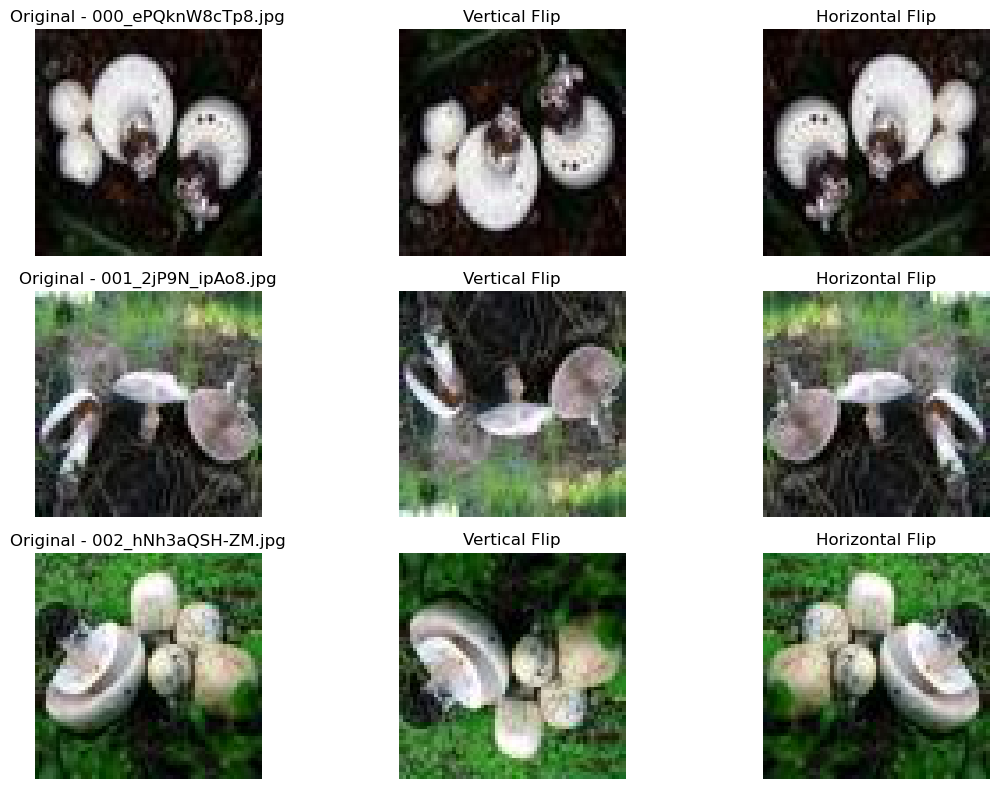

In [36]:
# Visually compare original images with their vertically and horizontally flipped versions.

# Choose a class directory
class_name = 'Agaricus'  
class_dir = resized_data_path / class_name

# Select a few images to demonstrate flipping
selected_images = list(class_dir.glob('*.jpg'))[:3]  

# Display the images before and after flipping
plt.figure(figsize=(12, 8))

for i, image_path in enumerate(selected_images, start=1):
    with Image.open(image_path) as img:
        # Original image
        plt.subplot(3, 3, 3 * (i - 1) + 1)
        plt.imshow(img)
        plt.title(f"Original - {image_path.name}")
        plt.axis('off')

        # Vertical flip
        img_v_flip = ImageOps.flip(img)
        plt.subplot(3, 3, 3 * (i - 1) + 2)
        plt.imshow(img_v_flip)
        plt.title("Vertical Flip")
        plt.axis('off')

        # Horizontal flip
        img_h_flip = ImageOps.mirror(img)
        plt.subplot(3, 3, 3 * (i - 1) + 3)
        plt.imshow(img_h_flip)
        plt.title("Horizontal Flip")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [44]:
# Preprocessing, loading, and normalization of the images and labels

def load_images_and_labels(class_dirs):
    images = []
    labels = []
    for class_dir in class_dirs:
        for image_path in class_dir.glob('*.jpg'):
            with Image.open(image_path) as img:
                # Convert to RGB and resize
                img_converted = img.convert('RGB')
                img_resized = img_converted.resize((64, 64))
                images.append(np.array(img_resized))
                labels.append(class_dir.name)
    return np.array(images), np.array(labels)

# Load images and labels
X, y = load_images_and_labels(resized_data_path.iterdir())

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the datasets
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training label size: {y_train.shape}")
print(f"Testing label size: {y_test.shape}")

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the training labels and transform them to integers
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the test labels to integers using the same encoder
y_test_encoded = label_encoder.transform(y_test)

# Now check the types again
print(y_train_encoded.shape, y_train_encoded.dtype)
print(y_test_encoded.shape, y_test_encoded.dtype)

def normalize_images(images):
    images = images.astype('float32')
    images /= 255.0
    return images

X_train_normalized = normalize_images(X_train)
X_test_normalized = normalize_images(X_test)

Training set size: (6984, 64, 64, 3)
Testing set size: (1747, 64, 64, 3)
Training label size: (6984,)
Testing label size: (1747,)
(6984,) int64
(1747,) int32


In [45]:
# Display the shape and data type of the normalized training and testing image sets 

print(X_train_normalized.shape, X_train_normalized.dtype)
print(y_train_encoded.shape, y_train_encoded.dtype)
print(X_test_normalized.shape, X_test_normalized.dtype)
print(y_test_encoded.shape, y_test_encoded.dtype)

(6984, 64, 64, 3) float32
(6984,) int64
(1747, 64, 64, 3) float32
(1747,) int32


Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_266 (Conv2D)         (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_266 (MaxPool  (None, 30, 30, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_267 (Conv2D)         (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_267 (MaxPool  (None, 14, 14, 16)        0         
 ing2D)                                                          
                                                                 
 flatten_133 (Flatten)       (None, 3136)              0         
                                                                 
 dense_266 (Dense)           (None, 64)             

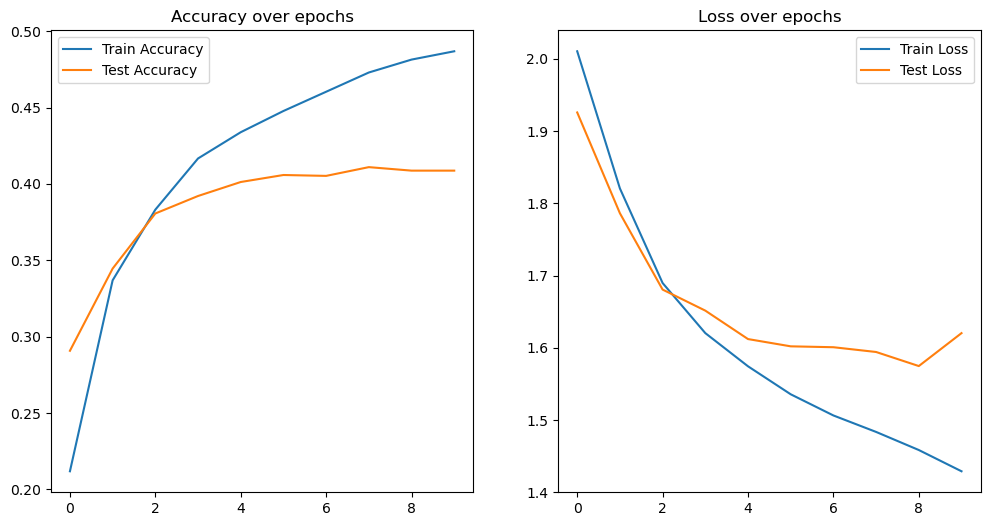

In [47]:
# Defines, compiles, trains, and visualizes 
# the performance of a convolutional neural network (CNN) model for image classification.

input_shape = (64, 64, 3)

# Define the model
test_model = Sequential([
    # Conv1: 16 channels, 5x5 window, stride 1, no padding
    Conv2D(16, (5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='valid'),
    
    # Maxpool1: 2x2 window, stride 2, no padding
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Conv2: 16 channels (same as Conv1), 3x3 window, stride 1, no padding
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu', padding='valid'),
    
    # Maxpool2: 2x2 window, stride 2, no padding
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Flatten the convolutions
    Flatten(),
    
    # Hidden dense layer
    Dense(units=64, activation='relu'),
    
    # Output layer
    Dense(units=8),  # There are 8 classes for the classification task
    
    # Softmax to probabilities
    Softmax()
])

# Compile the model
test_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the shapes
test_model.summary()
history = test_model.fit(X_train_normalized, y_train_encoded, validation_data=(X_test_normalized, y_test_encoded), epochs=10, batch_size=32)

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [52]:
#  Create a Convolutional Neural Network (CNN) model for image classification tasks.

conv_channels_options = [8, 16, 24]
conv_windows = [(3, 3), (5, 5), (7, 7)]
dense_dims = [64, 128, 256]  

def create_cnn(input_shape, conv_window, conv_channels, dense_dim):
    model = Sequential([
        Conv2D(conv_channels, conv_window, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(2),
        Conv2D(conv_channels * 2, conv_window, activation='relu', padding='same'),
        MaxPooling2D(2),
        Flatten(),
        Dense(dense_dim, activation='relu'),
        Dropout(0.5),  # Using dropout for regularization
        Dense(8),  
        Softmax()
    ])
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

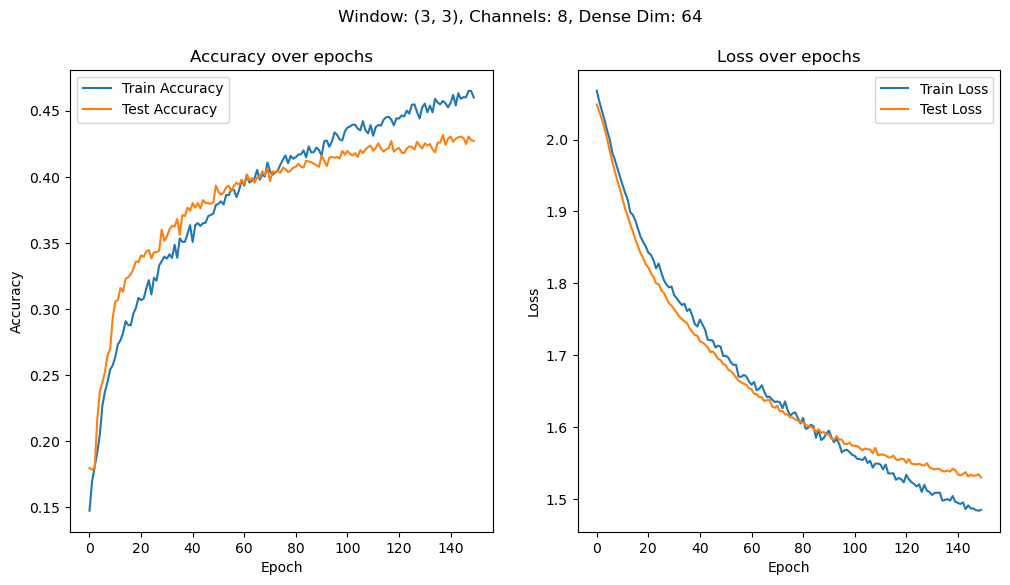

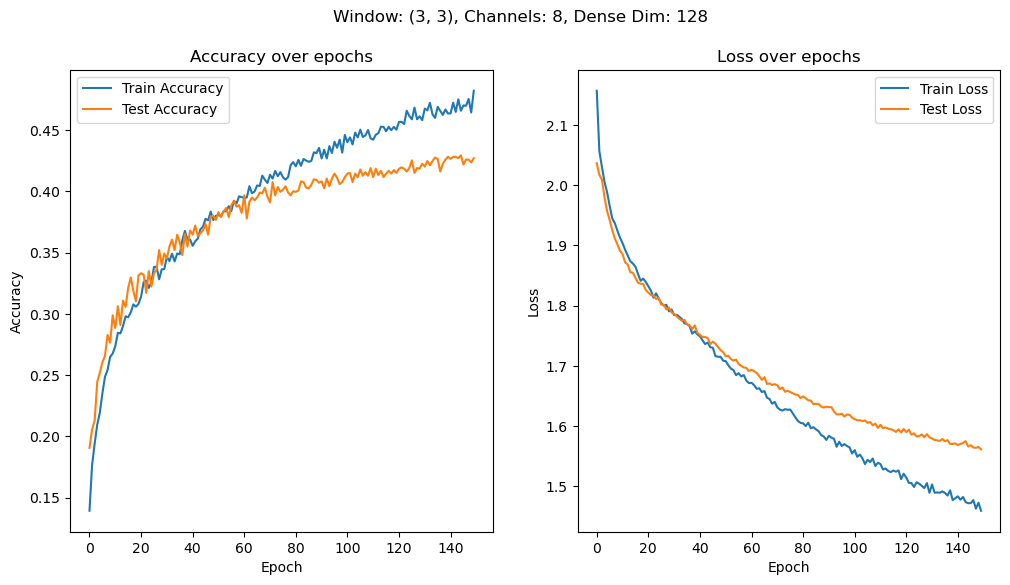

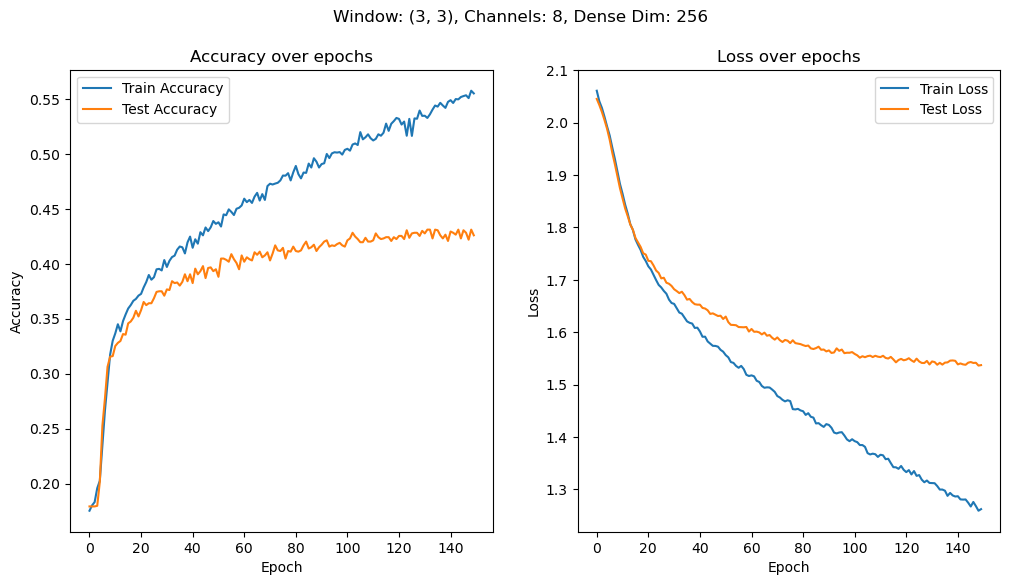

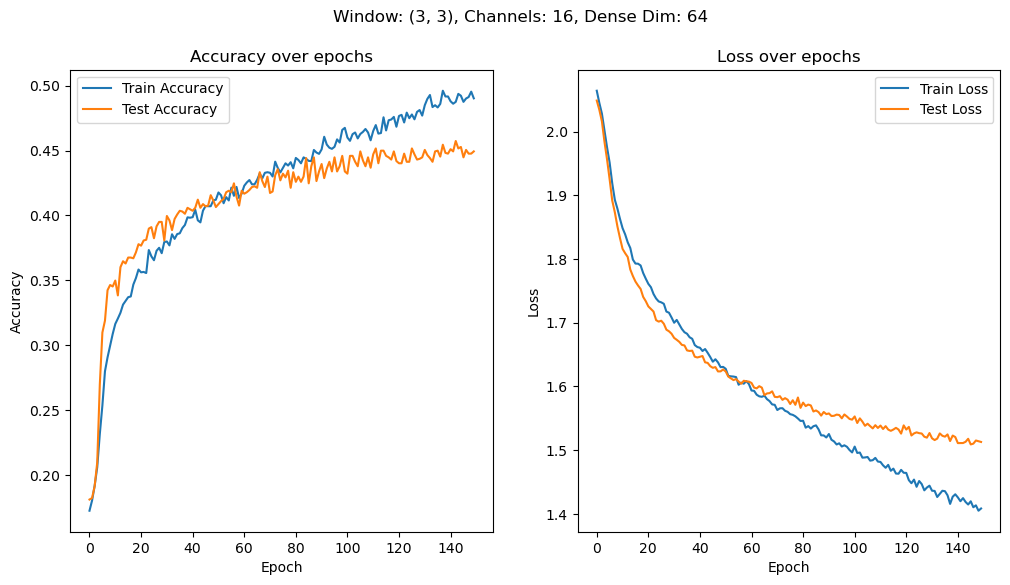

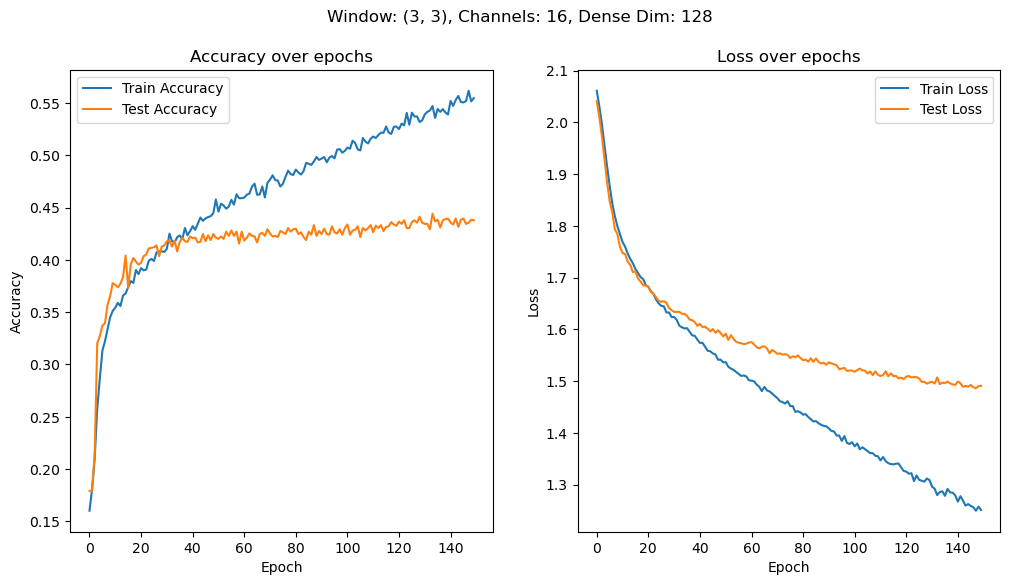

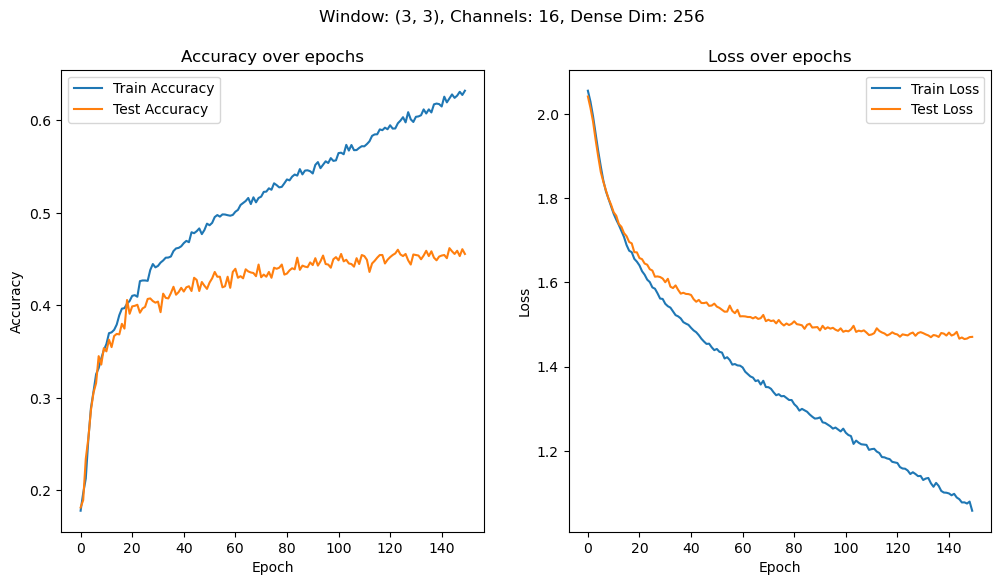

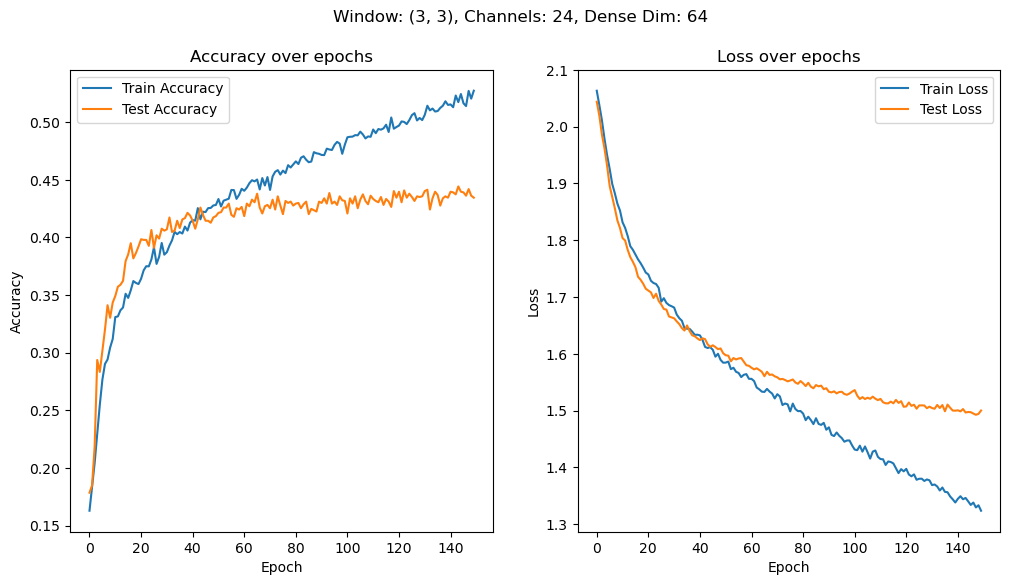

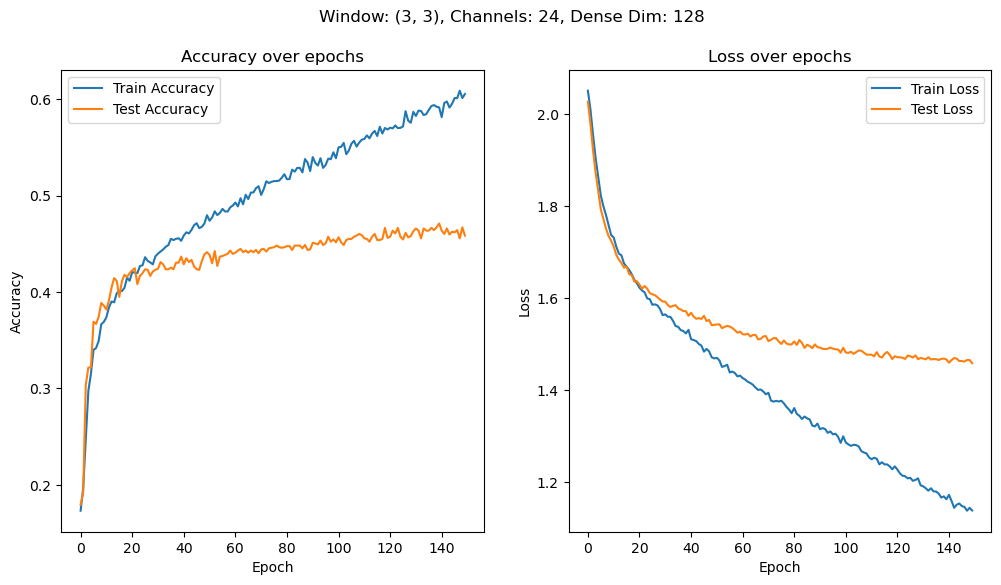

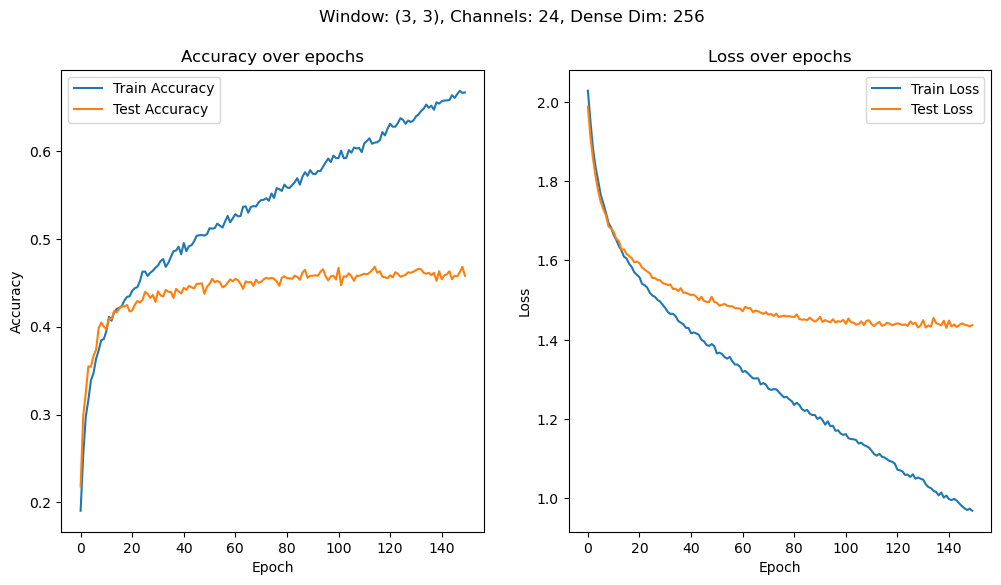

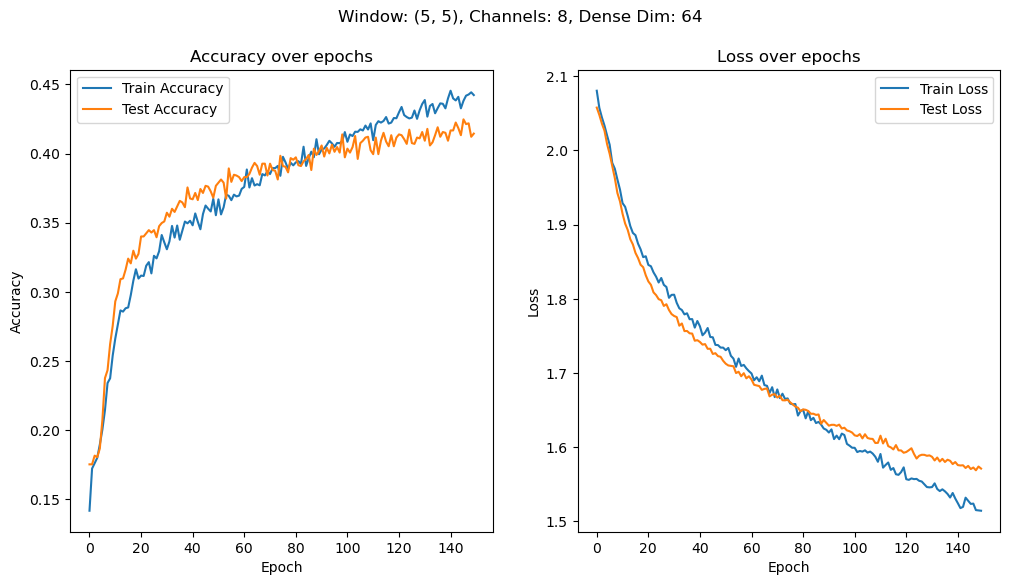

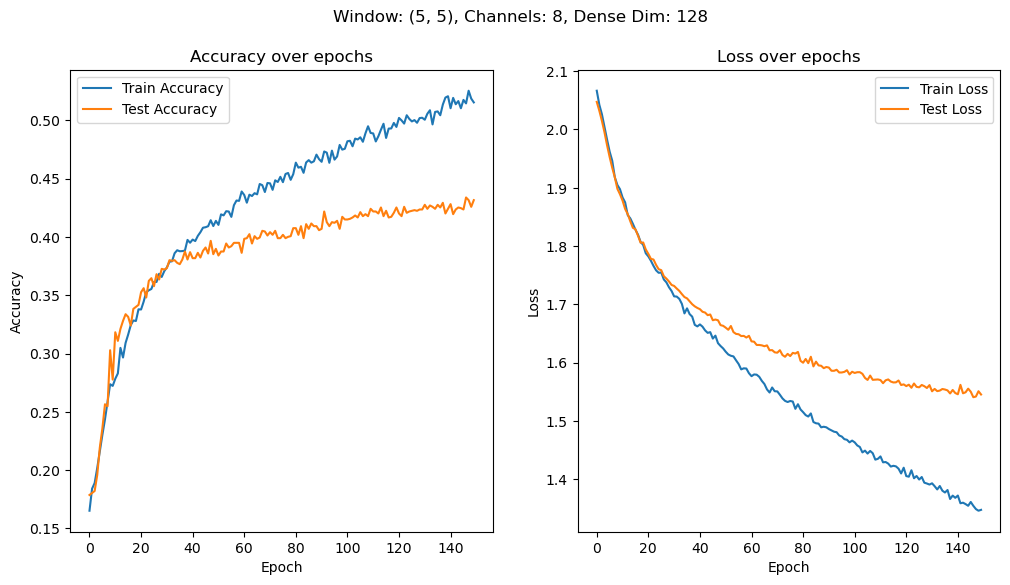

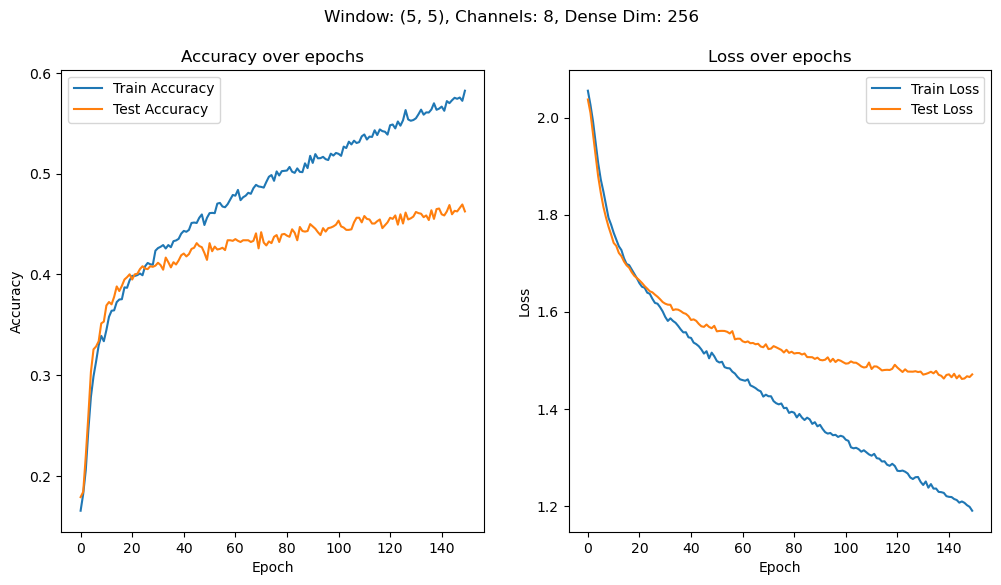

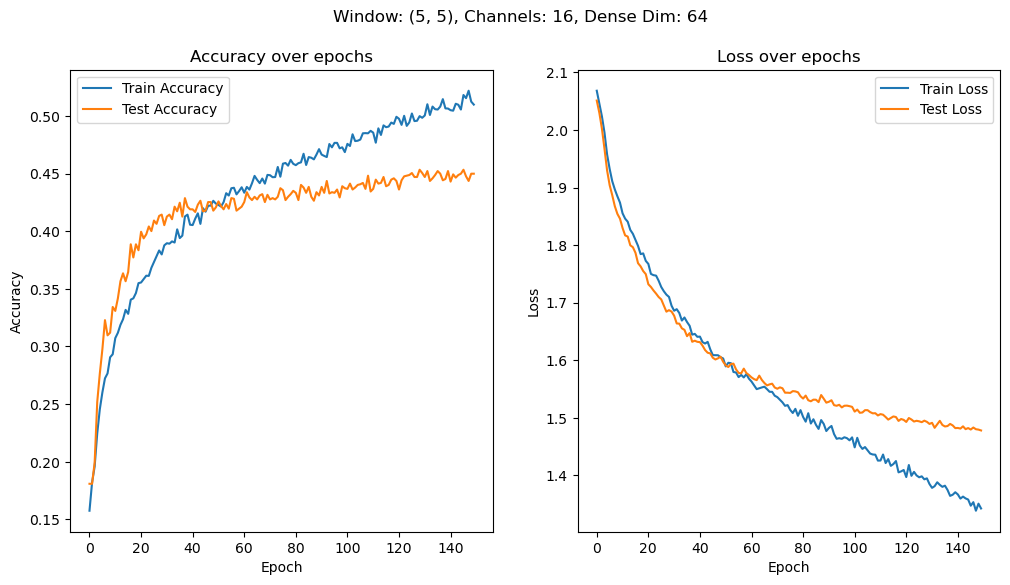

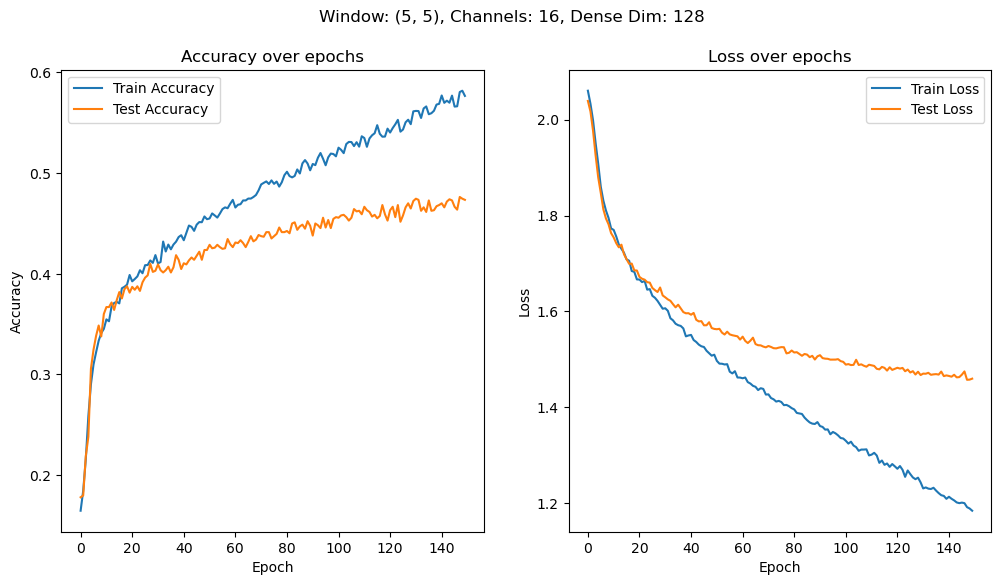

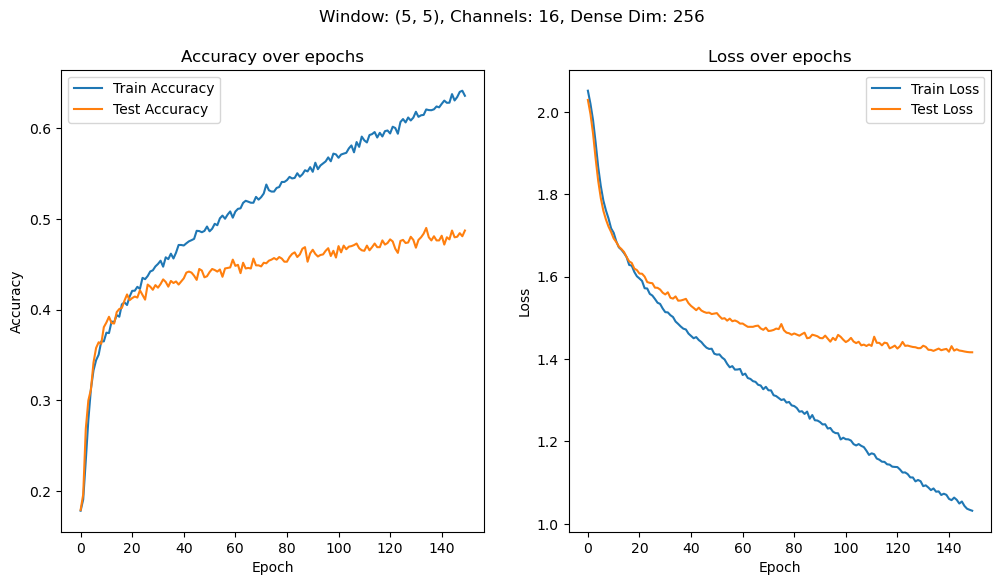

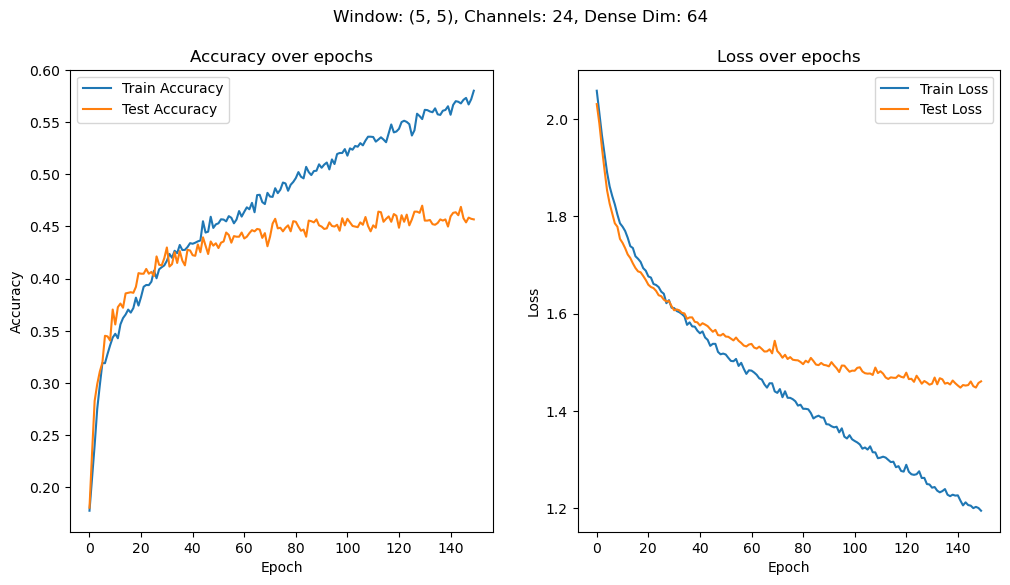

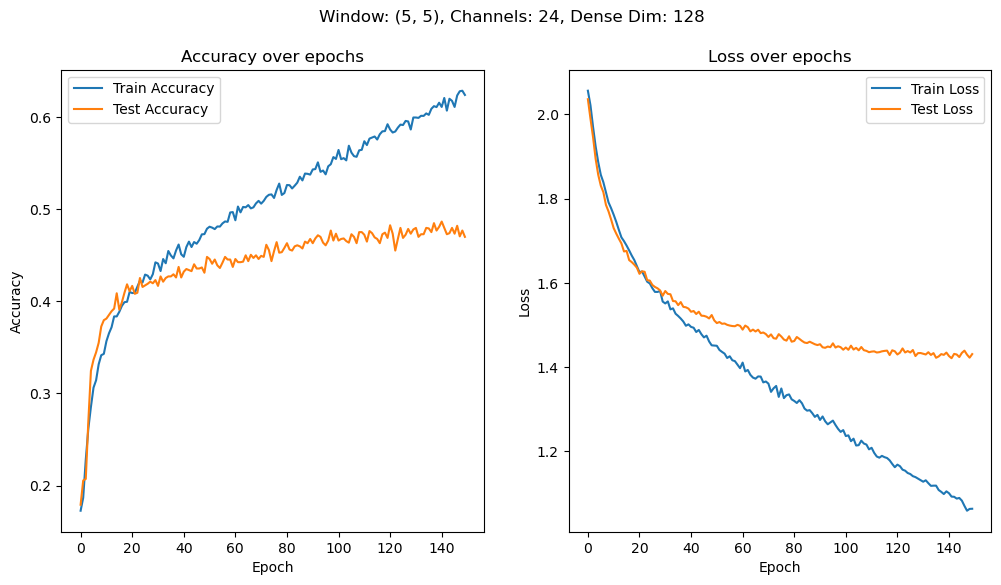

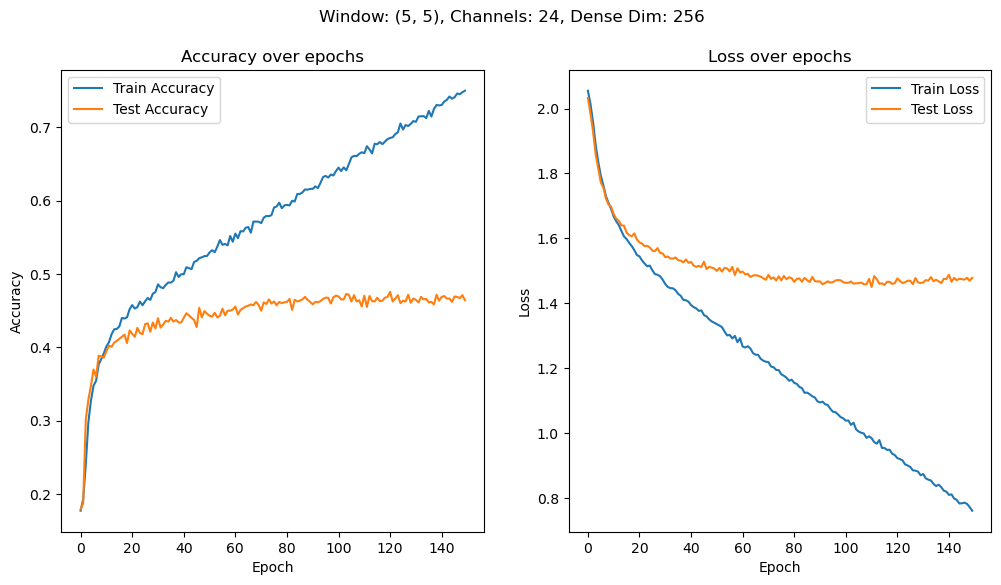

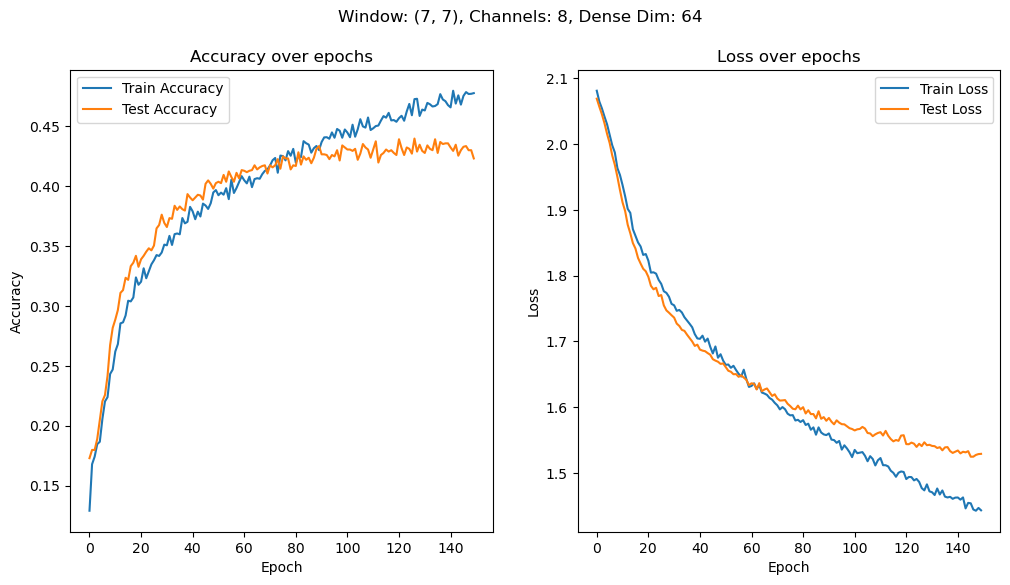

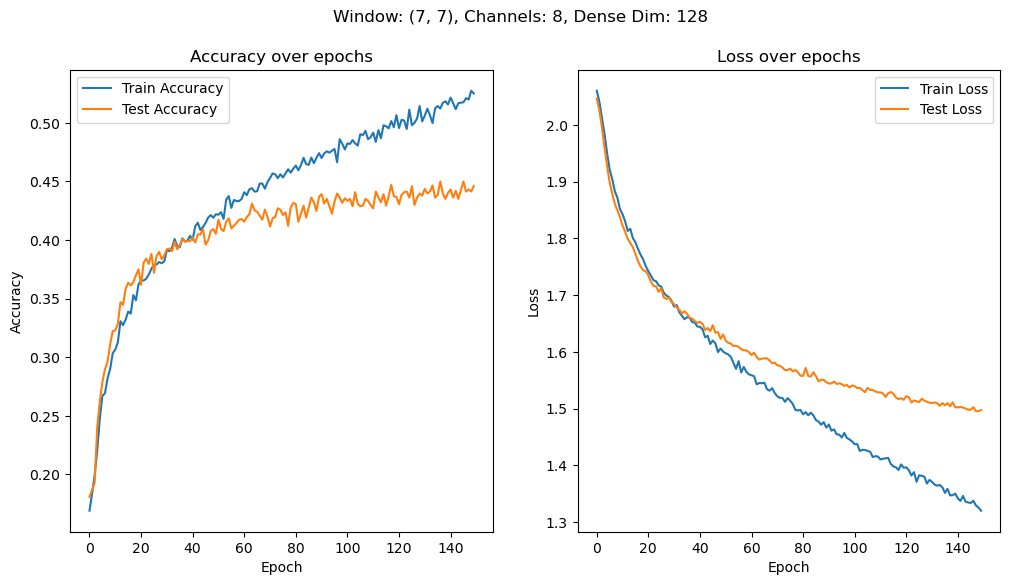

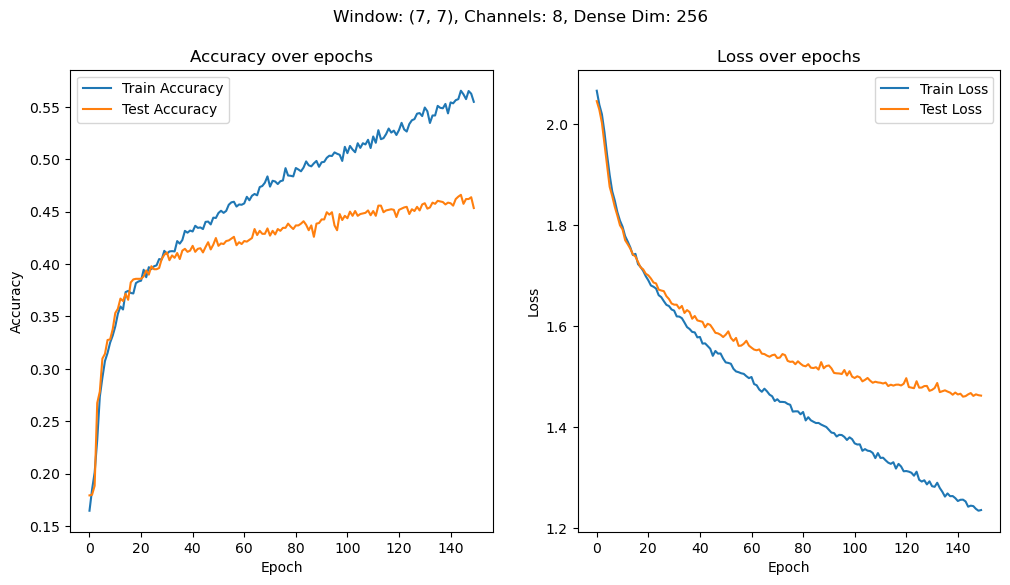

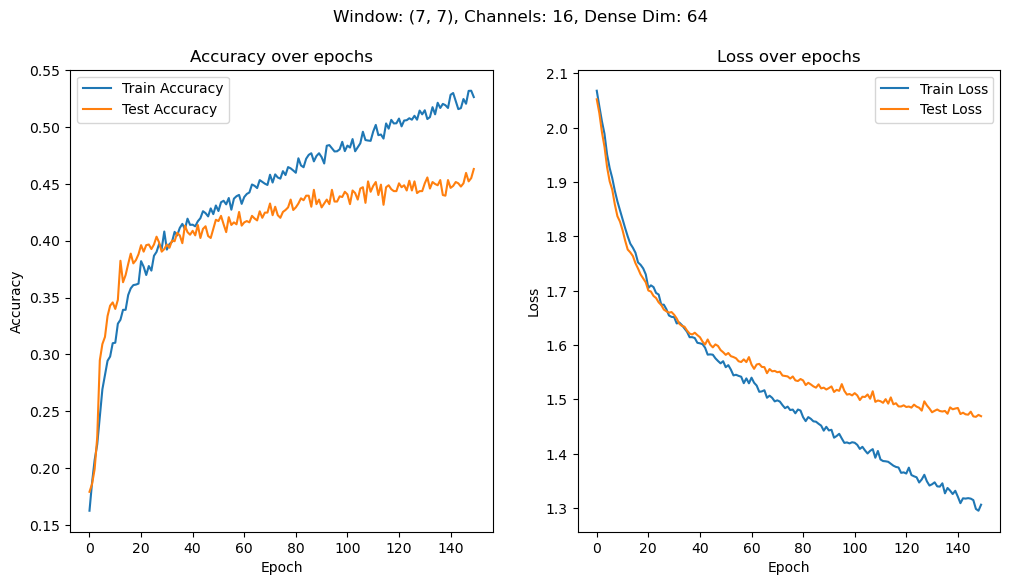

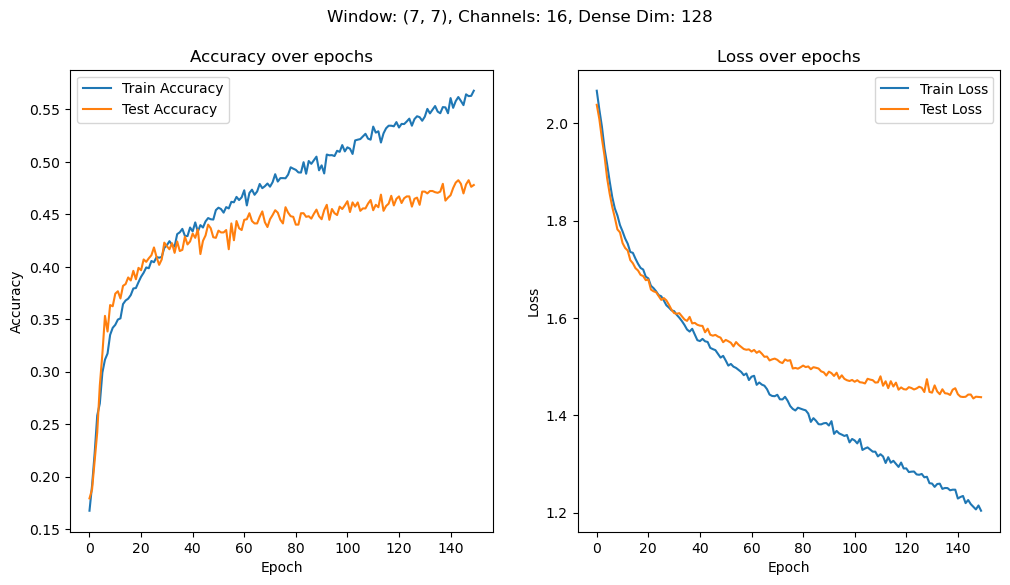

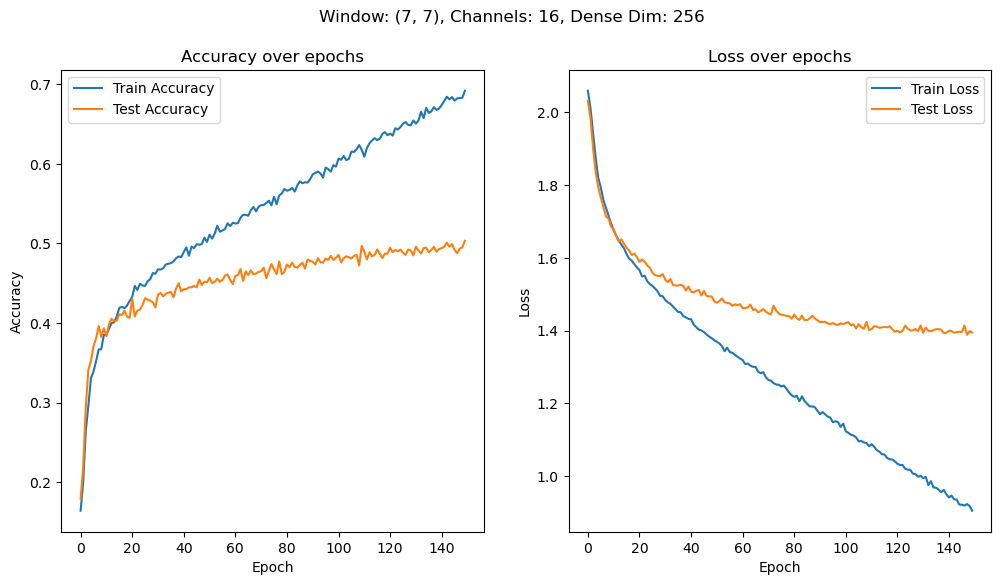

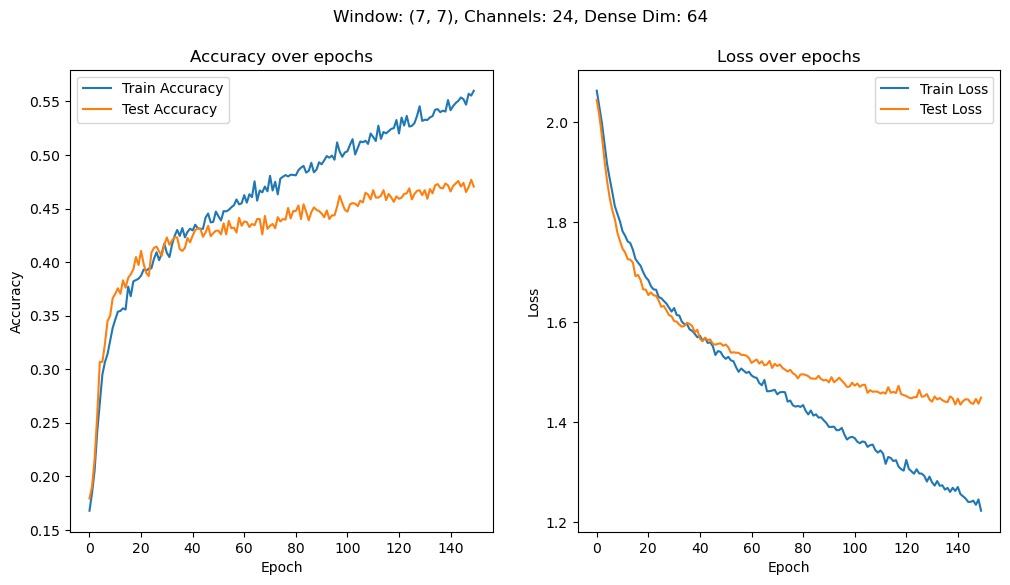

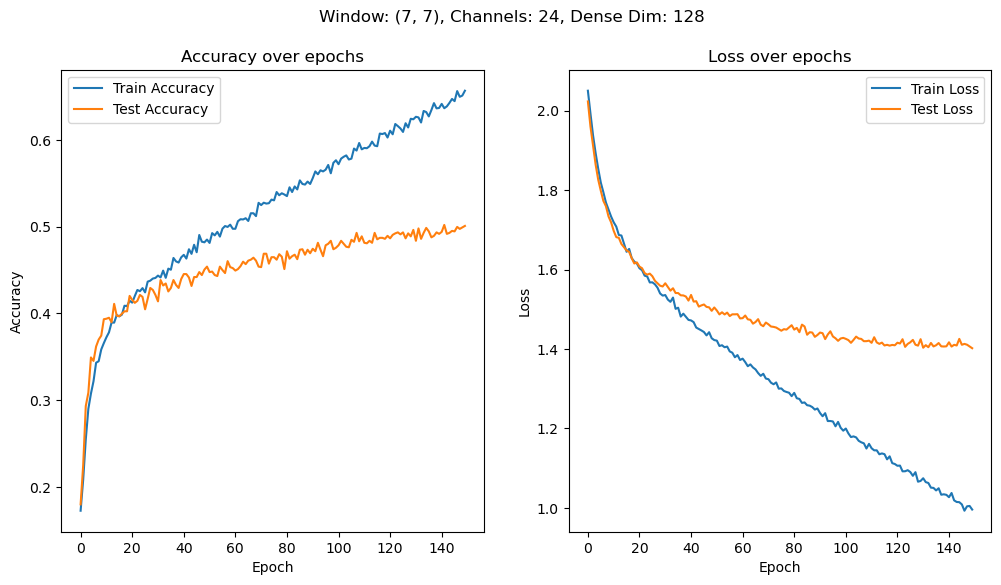

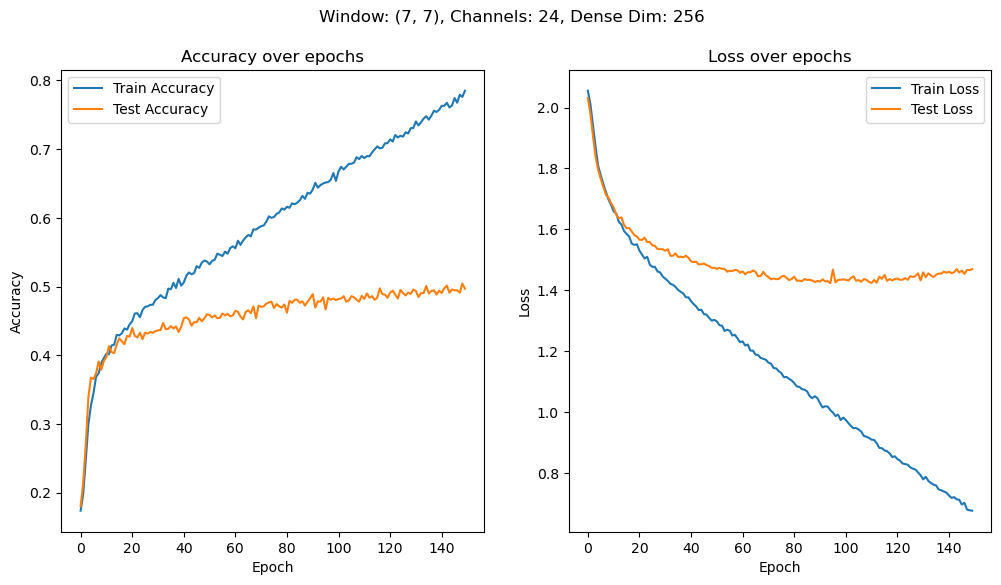

In [54]:
# Training

# Store the best performance metrics in a dataframe
results = []
start_time = time.time()
for conv_window in conv_windows:
    for conv_channels in conv_channels_options:
        for dense_dim in dense_dims:
            model = create_cnn(input_shape, conv_window, conv_channels, dense_dim)
            history = model.fit(
                X_train_normalized, y_train_encoded,
                validation_data=(X_test_normalized, y_test_encoded),
                epochs=150,
                verbose=0,
                batch_size=32
            )
            
            # Find the best epoch for this configuration
            best_epoch = np.argmax(history.history['val_accuracy'])
            best_train_accuracy = history.history['accuracy'][best_epoch]
            best_test_accuracy = history.history['val_accuracy'][best_epoch]
            best_train_loss = history.history['loss'][best_epoch]
            best_test_loss = history.history['val_loss'][best_epoch]
            
            end_time = time.time()
            training_time = end_time - start_time

           # Append results to the list
            results.append({
                'Conv_Window': conv_window,
                'Conv_Channels': conv_channels,
                'Dense_Dim': dense_dim,
                'Best_Epoch': best_epoch + 1,
                'Best_Train_Accuracy': best_train_accuracy,
                'Best_Test_Accuracy': best_test_accuracy,
                'Best_Train_Loss': best_train_loss,
                'Best_Test_Loss': best_test_loss,
                'Training_Time (s)': training_time
            })
            # Reset start_time for the next iteration
            start_time = time.time()

            # Plot accuracy and loss
            plt.figure(figsize=(12, 6))
            plt.suptitle(f'Window: {conv_window}, Channels: {conv_channels}, Dense Dim: {dense_dim}')
            
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            plt.plot(history.history['val_accuracy'], label='Test Accuracy')
            plt.title('Accuracy over epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Test Loss') 
            plt.title('Loss over epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.show()

In [55]:
# Evaluate different CNN architectures performance, 
# and visualize the training process to select the best model configuration

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Create a DataFrame from the results list
performance_metrics = pd.DataFrame(results)

# Display the performance metrics
performance_metrics['Accuracy %'] = performance_metrics['Best_Test_Accuracy'] * 100
print(performance_metrics[['Conv_Window', 'Conv_Channels', 'Dense_Dim', 'Best_Epoch', 'Accuracy %', 'Training_Time (s)']])

   Conv_Window  Conv_Channels  Dense_Dim  Best_Epoch  Accuracy %  Training_Time (s)
0       (3, 3)              8         64         138   43.159702         164.497986
1       (3, 3)              8        128         145   42.930737         181.364500
2       (3, 3)              8        256         132   43.102461         219.548320
3       (3, 3)             16         64         143   45.735547         260.281276
4       (3, 3)             16        128         134   44.419003         308.483271
5       (3, 3)             16        256         144   46.193475         399.897914
6       (3, 3)             24         64         144   44.419003         413.033085
7       (3, 3)             24        128         140   47.109330         500.397798
8       (3, 3)             24        256         115   46.823126         667.861390
9       (5, 5)              8         64         146   42.472810         220.346781
10      (5, 5)              8        128         147   43.388668         254

## Best Performance analysis

### Conv_Window = 5    Conv_Channels  =    16   Dense_Dim =   256      

Based on the results, it appears that as Conv_Window, Conv_Channels, and Dense_Dim increase, accuracy also increases, 
but so does training duration. Therefore, considering a balance between the two, 
I choose the combination model with Conv_Window = 5, Conv_Channels = 16, and Dense_Dim = 256. 
With this setup, my training duration is not excessively long, yet the accuracy remains at an acceptable level.

Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_390 (Conv2D)         (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_390 (MaxPool  (None, 30, 30, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_391 (Conv2D)         (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_391 (MaxPool  (None, 14, 14, 16)        0         
 ing2D)                                                          
                                                                 
 flatten_195 (Flatten)       (None, 3136)              0         
                                                                 
 dense_390 (Dense)           (None, 256)            

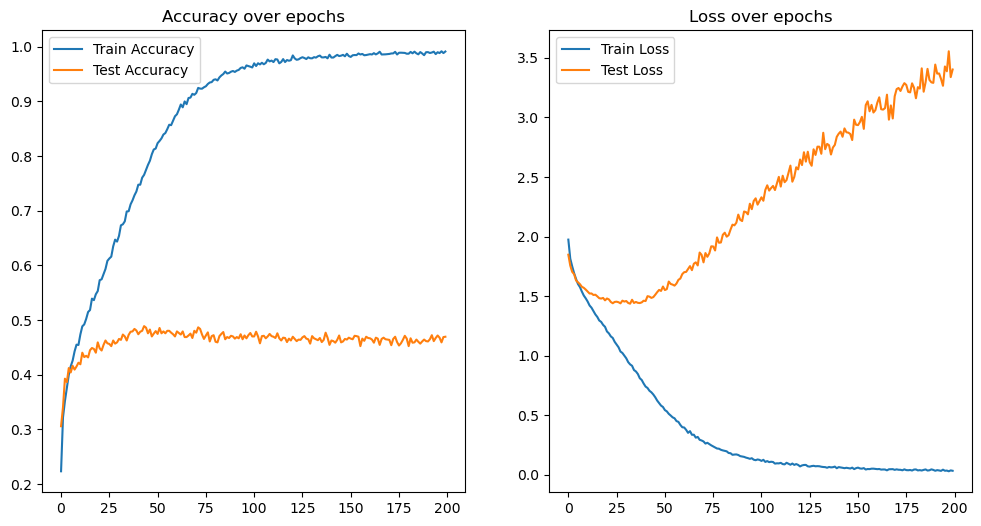

In [59]:
#Best Model
# Define the model
best_model = Sequential([
    Conv2D(16, (5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='valid'),

    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Conv2: 16 channels (same as Conv1), 3x3 window, stride 1, no padding
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu', padding='valid'),
    
    # Maxpool2: 2x2 window, stride 2, no padding
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Flatten the convolutions
    Flatten(),
    
    # Hidden dense layer
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(units=8),  
    
    # Softmax to probabilities
    Softmax()
])

# Compile the model
best_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the shapes
best_model.summary()
start_time = time.time()

best_model_history = best_model.fit(X_train_normalized, y_train_encoded, validation_data=(X_test_normalized, y_test_encoded), epochs=200,
                         verbose = 0, batch_size=32)
end_time = time.time()
# Calculate total training time
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")


# Find the epoch with the highest test accuracy
highest_val_accuracy = max(best_model_history.history['val_accuracy'])
highest_epoch = best_model_history.history['val_accuracy'].index(highest_val_accuracy) + 1 
print(f"Highest validation accuracy: {highest_val_accuracy:.4f} at epoch: {highest_epoch}")


# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_model_history.history['loss'], label='Train Loss')
plt.plot(best_model_history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

55/55 [==============================] - 0s 4ms/step


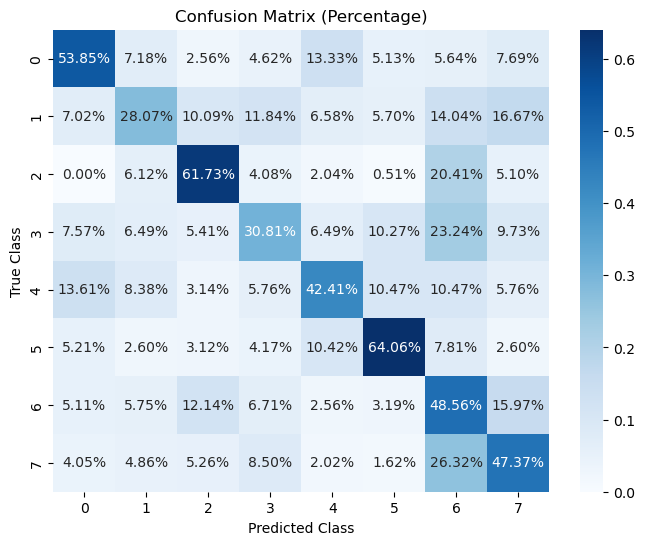

Classes with the highest confusion coefficient: 7 and 6


In [63]:
# Confusion matrix
predictions = best_model.predict(X_test_normalized)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_encoded, predicted_classes)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

confusion_coefficients = cm / np.sum(cm, axis=1, keepdims=True)

np.fill_diagonal(confusion_coefficients, 0)

CL1, CL2 = np.unravel_index(np.argmax(confusion_coefficients), confusion_coefficients.shape)

print(f"Classes with the highest confusion coefficient: {CL1} and {CL2}")

In [64]:
# filters a normalized dataset to focus on the two classes 
# and then adjusts the labels for binary classification

train_indices = (y_train_encoded == 6) | (y_train_encoded == 7)
X_train_filtered = X_train_normalized[train_indices]
y_train_filtered = y_train_encoded[train_indices]

test_indices = (y_test_encoded == 6) | (y_test_encoded == 7)
X_test_filtered = X_test_normalized[test_indices]
y_test_filtered = y_test_encoded[test_indices]

y_train_filtered_binary = y_train_filtered - 6
y_test_filtered_binary = y_test_filtered - 6

print(X_train_filtered.shape, X_train_filtered.dtype)
print(y_train_filtered_binary.shape, y_train_filtered_binary.dtype)
print(X_test_filtered.shape, X_test_filtered.dtype)
print(y_test_filtered_binary.shape, y_test_filtered_binary.dtype)

#Lactarius, Image Count: 1563
#Russula, Image Count: 1147

(2150, 64, 64, 3) float32
(2150,) int64
(560, 64, 64, 3) float32
(560,) int32


Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_396 (Conv2D)         (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_396 (MaxPool  (None, 30, 30, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_397 (Conv2D)         (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_397 (MaxPool  (None, 14, 14, 16)        0         
 ing2D)                                                          
                                                                 
 flatten_198 (Flatten)       (None, 3136)              0         
                                                                 
 dense_396 (Dense)           (None, 256)            

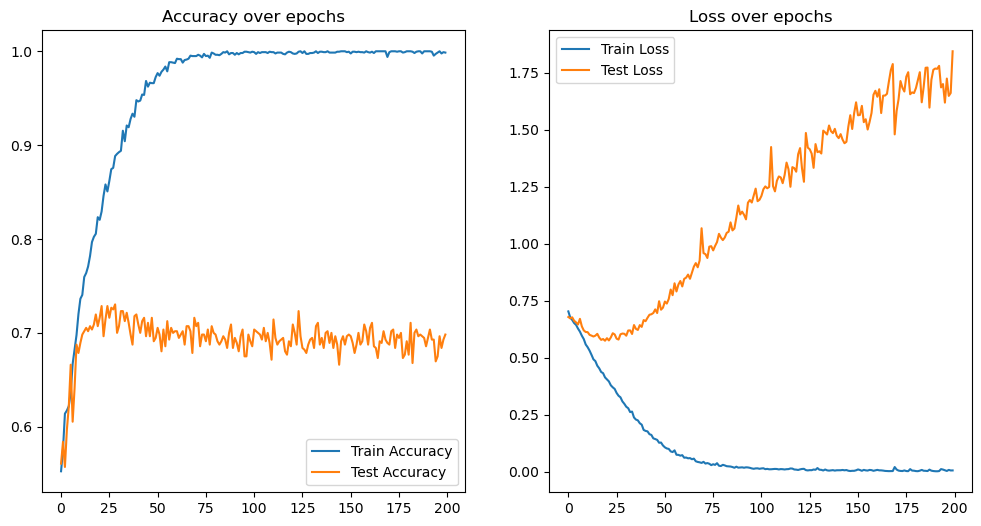

In [67]:
# Use the best windows + channels configuration
# to implement a new CNN classifier involving only the two classes CL6 and CL7

# Define the model
best_model_67 = Sequential([
    Conv2D(16, (5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='valid'),

    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Conv2: 16 channels (same as Conv1), 3x3 window, stride 1, no padding
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu', padding='valid'),
    
    # Maxpool2: 2x2 window, stride 2, no padding
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Flatten the convolutions
    Flatten(),
    
    # Hidden dense layer
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(units=2),  
    
    # Softmax to probabilities
    Softmax()
])

# Compile the model
best_model_67.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the shapes
best_model_67.summary()
start_time = time.time()

best_model_67_history = best_model_67.fit(X_train_filtered, y_train_filtered_binary,
                                          validation_data=(X_test_filtered, y_test_filtered_binary),
                                          epochs=200,verbose = 0, batch_size=32)
end_time = time.time()
# Calculate total training time
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

# Find the epoch with the highest test accuracy
highest_val_accuracy = max(best_model_67_history.history['val_accuracy'])
highest_epoch = best_model_67_history.history['val_accuracy'].index(highest_val_accuracy) + 1 
print(f"Highest validation accuracy: {highest_val_accuracy:.4f} at epoch: {highest_epoch}")

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_model_67_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_model_67_history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_model_67_history.history['loss'], label='Train Loss')
plt.plot(best_model_67_history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

18/18 [==============================] - 0s 4ms/step


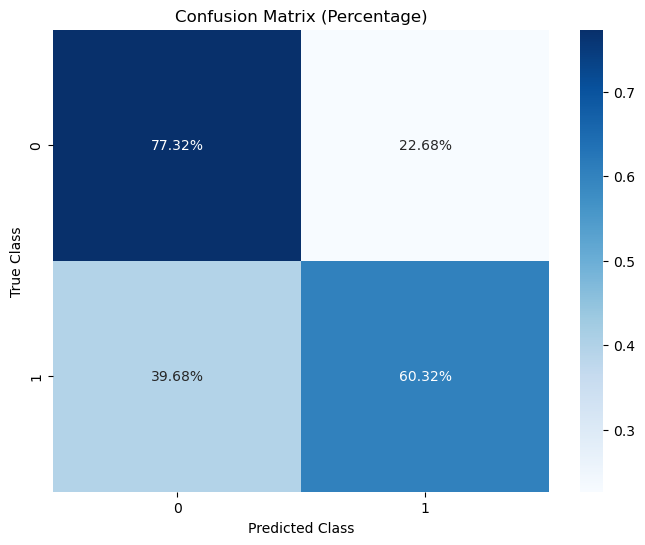

In [70]:
# Confusion matrix of these two classes.
predictions = best_model_67.predict(X_test_filtered)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_filtered_binary, predicted_classes)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

18/18 [==============================] - 0s 5ms/step


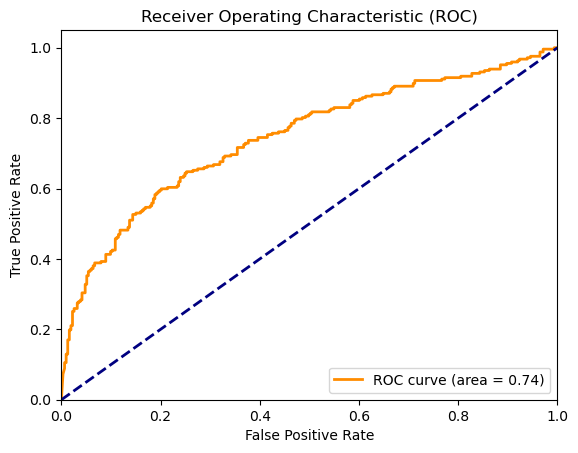

The area under the ROC curve (AUC): 0.74


In [80]:
# ROC
probabilities = best_model_67.predict(X_test_filtered)

if probabilities.shape[1] == 2:  
    probabilities = probabilities[:, 1]  
    
fpr, tpr, thresholds = roc_curve(y_test_filtered_binary, probabilities)

roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"The area under the ROC curve (AUC): {roc_auc:.2f}")
